In [1]:
#Install & Imports, Environment setup

!pip install gymnasium[box2d] torch matplotlib

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt

# create the environment
env = gym.make("CartPole-v1", render_mode=None)
state_dim  = env.observation_space.shape[0]   # 4
action_dim = env.action_space.n              # 2

# Hyperparameters
seed       = 42
gamma      = 0.99      # discount
lr         = 1e-3      # learning rate
batch_size = 64
buffer_size= 10_000
eps_start  = 1.0
eps_end    = 0.01
eps_decay  = 500       # decay rate for epsilon-greedy

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
env.reset(seed=seed)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.4 MB/s eta 0:00:00
  err

(array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32),
 {})

In [2]:
# Q-Network definition & Replay Buffer

class QNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim)
        )
    def forward(self, x):
        return self.net(x)

# simple replay buffer
from collections import deque, namedtuple
Transition = namedtuple("Transition", ("s","a","r","s2","done"))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buf = deque(maxlen=capacity)
    def push(self, *args):
        self.buf.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.buf, batch_size)
    def __len__(self):
        return len(self.buf)

# instantiate networks, optimizer, buffer
policy_net = QNetwork(state_dim, action_dim)
target_net = QNetwork(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
buffer    = ReplayBuffer(buffer_size)


In [8]:
# Training loop

def select_action(state, steps_done):
    eps = eps_end + (eps_start - eps_end) * \
          np.exp(-1. * steps_done / eps_decay)
    if random.random() < eps:
        return random.randrange(action_dim)
    else:
        with torch.no_grad():
            qvals = policy_net(torch.FloatTensor(state))
            return qvals.argmax().item()

num_episodes = 1000
target_update = 10
steps_done = 0
episode_rewards = []

for ep in range(num_episodes):
    state, _ = env.reset()
    total_r = 0
    done = False
    while not done:
        action = select_action(state, steps_done)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_r += reward
        steps_done += 1

        # learn once buffer is large enough
        if len(buffer) >= batch_size:
            batch = Transition(*zip(*buffer.sample(batch_size)))
            S  = torch.FloatTensor(batch.s)
            A  = torch.LongTensor(batch.a).unsqueeze(1)
            R  = torch.FloatTensor(batch.r).unsqueeze(1)
            S2 = torch.FloatTensor(batch.s2)
            D  = torch.FloatTensor(batch.done).unsqueeze(1)

            # current Q
            Q  = policy_net(S).gather(1, A)
            # target Q
            with torch.no_grad():
                Q2 = target_net(S2).max(1)[0].unsqueeze(1)
                Q_target = R + gamma * Q2 * (1 - D)

            loss = nn.functional.mse_loss(Q, Q_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    episode_rewards.append(total_r)

    # update target network
    if ep % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if ep % 50 == 0:
        print(f"Episode {ep:3d}\tReward: {total_r:.1f}")

print("Training complete")

# 4) Network summary
print("Learned Q-Network:")
print(policy_net)

# 5) compute final 100‐episode average (to see how well it learned)
avg_last_100 = sum(episode_rewards[-100:]) / 100
print(f"Average reward over last 100 episodes: {avg_last_100:.2f}")



Episode   0	Reward: 26.0
Episode  50	Reward: 133.0
Episode 100	Reward: 138.0
Episode 150	Reward: 171.0
Episode 200	Reward: 215.0
Episode 250	Reward: 79.0
Episode 300	Reward: 140.0
Episode 350	Reward: 131.0
Episode 400	Reward: 148.0
Episode 450	Reward: 128.0
Episode 500	Reward: 500.0
Episode 550	Reward: 461.0
Episode 600	Reward: 345.0
Episode 650	Reward: 102.0
Episode 700	Reward: 500.0
Episode 750	Reward: 500.0
Episode 800	Reward: 500.0
Episode 850	Reward: 267.0
Episode 900	Reward: 252.0
Episode 950	Reward: 290.0
Training complete
Learned Q-Network:
QNetwork(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Average reward over last 100 episodes: 339.69


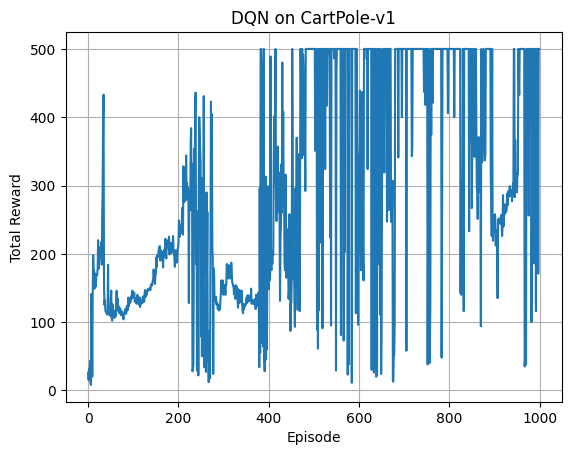

In [9]:
# Cell 4: Plot learning curve

plt.plot(episode_rewards)
plt.title("DQN on CartPole-v1")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()
